In [42]:
import numpy as np
import pandas as pd
import yfinance as yf

In [43]:
stock_symbol = 'SBIN.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [45]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,18.691147,18.978922,18.540184,18.823240,12.409934,43733533
1996-01-02,18.894005,18.964767,17.738192,18.224106,12.014931,56167280
1996-01-03,18.327892,18.568489,17.643839,17.738192,11.694572,68296318
1996-01-04,17.502312,17.832542,17.223972,17.676863,11.654140,86073880
1996-01-05,17.738192,17.785366,17.459852,17.577793,11.588825,76613039
...,...,...,...,...,...,...
2024-04-25,770.650024,814.400024,769.650024,812.700012,812.700012,36732974
2024-04-26,815.900024,816.900024,798.900024,801.299988,801.299988,14964358
2024-04-29,807.000000,831.250000,798.700012,826.500000,826.500000,27302732


In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [47]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [48]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [49]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
221/221 [==============================] - 8s 12ms/step - loss: 0.0028
Epoch 2/50
221/221 [==============================] - 3s 15ms/step - loss: 0.0010
Epoch 3/50
221/221 [==============================] - 3s 12ms/step - loss: 8.3899e-04
Epoch 4/50
221/221 [==============================] - 3s 12ms/step - loss: 9.0045e-04
Epoch 5/50
221/221 [==============================] - 3s 12ms/step - loss: 7.4999e-04
Epoch 6/50
221/221 [==============================] - 3s 14ms/step - loss: 6.7053e-04
Epoch 7/50
221/221 [==============================] - 3s 13ms/step - loss: 6.3803e-04
Epoch 8/50
221/221 [==============================] - 3s 12ms/step - loss: 5.8476e-04
Epoch 9/50
221/221 [==============================] - 3s 12ms/step - loss: 5.6946e-04
Epoch 10/50
221/221 [==============================] - 3s 12ms/step - loss: 5.3772e-04
Epoch 11/50
221/221 [==============================] - 3s 15ms/step - loss: 5.4076e-04
Epoch 12/50
221/221 [==============================] - 3s 12

1/1 [==============================] - 0s 34ms/step


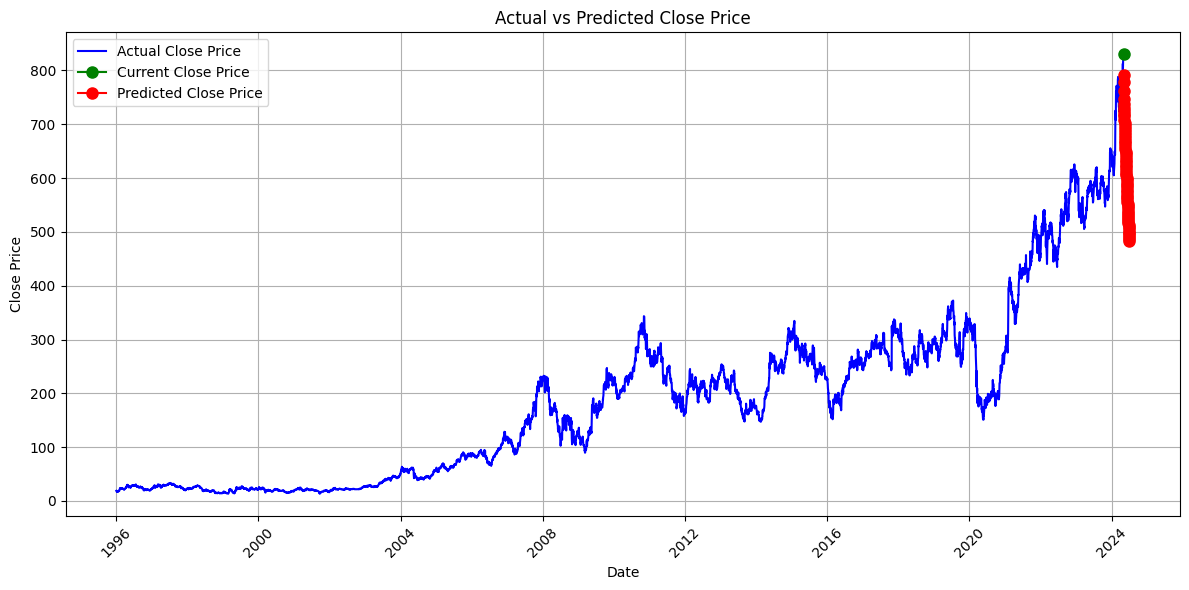

In [50]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
predicted_prices

array([792.199  , 778.5359 , 761.42834, 747.1163 , 737.1236 , 730.3379 ,
       725.03357, 719.9561 , 714.5669 , 708.83685, 702.9504 , 697.0956 ,
       691.3791 , 685.82513, 680.40955, 675.09424, 669.84717, 664.6493 ,
       659.49225, 654.3742 , 649.29584, 644.2582 , 639.26166, 634.3065 ,
       629.3925 , 624.51965, 619.6881 , 614.89795, 610.1494 , 605.4427 ,
       600.77783, 596.1548 , 591.5736 , 587.03394, 582.5355 , 578.07825,
       573.6616 , 569.2854 , 564.94904, 560.6524 , 556.3949 , 552.1762 ,
       547.9961 , 543.85406, 539.7499 , 535.68317, 531.65356, 527.66095,
       523.70496, 519.7854 , 515.9019 , 512.05444, 508.24265, 504.4664 ,
       500.72546, 497.0198 , 493.3491 , 489.71335, 486.11227, 482.54584],
      dtype=float32)

In [52]:
model.save('SBIN_NS.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [53]:
import joblib
joblib.dump(scaler, 'SBIN_NS_minmax_scaler.pkl')

['SBIN_NS_minmax_scaler.pkl']